## Comparing queries 

Ensuring that any modifications to Aleksandr's query results in the same numbers

In [209]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import os
import pandas_gbq
import matplotlib.pyplot as plt

%load_ext google.cloud.bigquery
BQ_PROJECT_ID = "dhh-ncr-stg"

CURRENT_DIR = Path(os.getcwd())
BASE_QUERY_PATH = CURRENT_DIR.parent / "queries"
GROUND_TRUTH_SQL_PATH = BASE_QUERY_PATH / "mape_calculation_gt.sql"
CANDIDATE_SQL_PATH = BASE_QUERY_PATH / "data_collection.sql"

PLOT_PATH = CURRENT_DIR.parent / "figures"

SEED = 13
rng = np.random.default_rng(SEED)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [10]:
try:
    with open(GROUND_TRUTH_SQL_PATH, 'r') as file:
        gt_query = file.read()
    print(f"Loaded SQL query: {len(gt_query)} characters")
except FileNotFoundError:
    print("SQL file not found")
except IOError:
    print("Error reading the file")

Loaded SQL query: 4161 characters


Loaded SQL query: 6166 characters


In [62]:
try:
    with open(CANDIDATE_SQL_PATH, 'r') as file:
        candidate_query = file.read()
    print(f"Loaded SQL query: {len(candidate_query)} characters")
except FileNotFoundError:
    print("SQL file not found")
except IOError:
    print("Error reading the file")

reco_sources = ['CEB', 'ML']
booking_sources = ['agent', 'vendor']

output = []
for rs in reco_sources:
    for bs in booking_sources:
        tmp = (
            pandas_gbq.read_gbq(
                candidate_query.format(RECO_SOURCE=rs, BOOKING_SOURCE=bs), 
                project_id=BQ_PROJECT_ID
            )
        )
        output.append(tmp)

df = pd.concat(output)

Loaded SQL query: 6207 characters
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [63]:
df.head()

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,bid_eur,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas
0,CEB,agent,GV_TN,650240,2025-06-01,Glovo,68519205cf8946a0e2494fc0,118.000000000,506,44,...,0.23,3.977273,-44.318182,0.280303,-4.075758,0.0,3.0,425.000000,29.000000,3.0
1,CEB,agent,PY_GT,216950,2025-06-01,Pedidosya,6840cf4895230073bff55326,75.000000000,165,52,...,0.45,2.966102,20.762712,0.474576,2.322034,0.0,3.0,243.220339,37.915254,3.0
2,CEB,agent,PY_NI,550892,2025-06-01,Pedidosya,6848a7851d9c29178538e5f5,51.000000000,212,11,...,0.24,3.061224,-9.693878,0.244898,-0.775510,0.0,3.0,146.428571,11.714286,3.0
3,CEB,agent,PY_NI,259393,2025-06-01,Pedidosya,6849e86c5deacde0cf53bf9c,55.000000000,133,4,...,0.15,3.061224,-9.693878,0.346939,-2.265306,0.0,3.0,158.673469,16.816327,3.0
4,CEB,agent,NP_HU,xy7n,2025-06-01,DH Europe,683da30bb0ff6d31a484f738,149.000000000,307,64,...,0.48,0.791139,88.449367,0.120253,14.044304,0.0,3.0,206.329114,31.962025,3.0


In [170]:
# this is weird. crazy high predictions. the largest has predicted clicks higher than all observed clicks.
# I am going to delete these. They are CEB only. We are interested here in comparing metrics. I don't think this will affect the discussion.
df.loc[df.adj_e_clicks < df.groupby(['global_entity_id', 'vendor_id']).cpc_clicks.sum().max() * 10]

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas,poisson_clicks
0,CEB,agent,GV_TN,650240,2025-06-01,Glovo,68519205cf8946a0e2494fc0,118.000000000,506,44,...,3.977273,-44.318182,0.280303,-4.075758,0.000000,3.000000,425.000000,29.000000,3.000000,534
1,CEB,agent,PY_GT,216950,2025-06-01,Pedidosya,6840cf4895230073bff55326,75.000000000,165,52,...,2.966102,20.762712,0.474576,2.322034,0.000000,3.000000,243.220339,37.915254,3.000000,178
2,CEB,agent,PY_NI,550892,2025-06-01,Pedidosya,6848a7851d9c29178538e5f5,51.000000000,212,11,...,3.061224,-9.693878,0.244898,-0.775510,0.000000,3.000000,146.428571,11.714286,3.000000,217
3,CEB,agent,PY_NI,259393,2025-06-01,Pedidosya,6849e86c5deacde0cf53bf9c,55.000000000,133,4,...,3.061224,-9.693878,0.346939,-2.265306,0.000000,3.000000,158.673469,16.816327,3.000000,125
4,CEB,agent,NP_HU,xy7n,2025-06-01,DH Europe,683da30bb0ff6d31a484f738,149.000000000,307,64,...,0.791139,88.449367,0.120253,14.044304,0.000000,3.000000,206.329114,31.962025,3.000000,277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,ML,vendor,PY_CL,537880,2025-06-01,Pedidosya,684a0e483dcb5e3e3678bf0e,33.000000000,179,1,...,2.773925,-1.000000,0.277393,-1.000000,-0.004574,3.505334,90.539528,8.153953,3.354379,192
514,ML,vendor,PY_CR,315169,2025-06-01,Pedidosya,6860dbbedc3564b86810b034,54.000000000,99,5,...,3.668523,10.000000,0.262037,0.000000,-0.012947,5.029325,208.100229,14.150016,4.330192,79
515,ML,vendor,PY_DO,491609,2025-06-01,Pedidosya,684aec7a40e7f028ec8d2749,44.000000000,230,15,...,1.456618,115.000000,0.189994,14.000000,-0.018079,7.934169,179.091197,22.359721,7.138700,232
516,ML,vendor,PY_EC,482913,2025-06-01,Pedidosya,68430d453f852ac4220c8a0b,53.000000000,662,69,...,1.827263,269.500000,0.170545,26.500000,-0.033273,6.883653,366.344926,35.538860,5.120158,641


In [171]:
df = df.loc[df.adj_e_clicks < df.groupby(['global_entity_id', 'vendor_id']).cpc_clicks.sum().max() * 10]

Relevant part of query, where `adj` is the table above

```
ape_t as (
SELECT *,
  SAFE_DIVIDE(ABS(cpc_clicks - adj_e_clicks) , cpc_clicks) * 100 as ape_c, 
  SAFE_DIVIDE(ABS(cpc_clicks - adj_e_orders) , cpc_clicks) * 100 as ape_o, 
  SAFE_DIVIDE(ABS(cpc_clicks - adj_e_roas) , cpc_clicks) * 100 as ape_r 
FROM adj
),

cl_groups as (
SELECT *,
   IF(cpc_clicks < 100, "<100", ">100")  as clicks_group 
FROM ape_t
)

SELECT 
  management_entity,
  clicks_group,
  COUNT(*) as total_campaigns,
  ROUND(AVG(ape_c), 0) as MAPE_clicks,
  ROUND(AVG(ape_o), 0) as MAPE_orders,
  ROUND(AVG(ape_r), 0) as MAPE_roas,
FROM cl_groups 
```

Note, that we're using `SAFE_DIVIDE`, [which returns null](https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions#safe_divide) when the denominator is zero. This means we don't include vendors with zero clicks in their forecast, even if they're relevant.

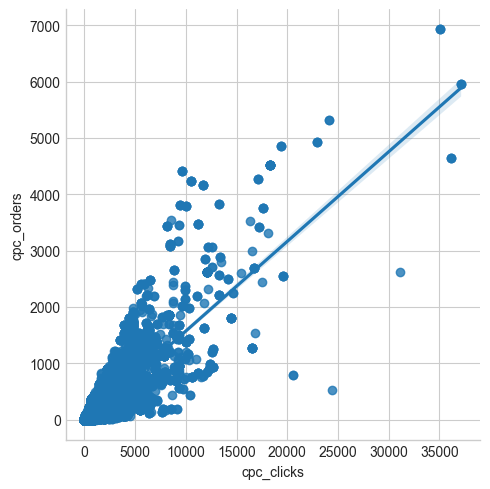

In [ ]:
sns.lmplot(data=df,
           x='cpc_revenue',
           y='cpc_orders')

In [172]:
df.loc[df.cpc_clicks < 100]

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas,poisson_clicks
8,CEB,agent,DJ_CZ,xn2g,2025-06-01,DH Europe,685be962675772164ec07436,44.000000000,62,5,...,0.111111,-7.777778,0.000000,0.000000,0.000000,3.000000,-2.888889,0.000000,3.000000,56
10,CEB,agent,PY_PY,494905,2025-06-01,Pedidosya,6862e493c8bdda941b785e56,37.000000000,57,3,...,4.054054,20.270270,0.243243,1.216216,0.000000,3.000000,170.270270,10.216216,3.000000,50
18,CEB,agent,PY_GT,547469,2025-06-01,Pedidosya,685c334658e007b49618cc7f,41.000000000,90,2,...,3.365385,-4.807692,0.057692,0.346154,0.000000,3.000000,133.173077,2.711538,3.000000,91
20,CEB,agent,TB_OM,757933,2025-06-01,Talabat,6855578846f1a2a33f623435,316.000000000,2,0,...,2.608696,-21.304348,0.095652,-0.947826,0.000000,3.000000,803.043478,29.278261,3.000000,2
31,CEB,agent,TB_OM,710039,2025-06-01,Talabat,6855578746f1a2a33f623426,339.000000000,0,0,...,1.388889,-8.333333,0.154321,-1.148148,0.000000,3.000000,462.500000,51.166667,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,ML,vendor,PY_AR,543347,2025-06-01,Pedidosya,684f5cf6178f95161c4b085b,53.000000000,12,0,...,3.406146,1.000000,0.296187,-2.000000,0.001784,2.983160,181.525731,13.697890,3.077692,10
478,ML,vendor,PY_AR,530206,2025-06-01,Pedidosya,68532bb47fc28ae599768540,36.000000000,54,0,...,2.680730,14.500000,0.659196,3.500000,-0.016395,7.449047,111.006262,27.231048,6.858819,49
491,ML,vendor,PY_EC,211005,2025-06-01,Pedidosya,6862c5859e408e6839f8da80,102.000000000,0,0,...,2.711927,67.500000,0.313624,6.500000,-0.009012,5.938027,344.116548,38.489669,5.018847,0
496,ML,vendor,PY_AR,322379,2025-06-01,Pedidosya,685dd76eeac3c0aa29bcedaa,34.000000000,35,2,...,2.896082,2.000000,0.170358,-1.000000,-0.004999,4.384734,100.466780,4.792164,4.214762,34


In [173]:
df['poisson_clicks'] = np.array(rng.poisson(df.cpc_clicks.values))

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_15079/3607100113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poisson_clicks'] = np.array(rng.poisson(df.cpc_clicks.values))


In [230]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)


def calculate_metrics(actual, predicted, weights):
    """Calculates and returns a dictionary of evaluation metrics."""
    if len(actual) == 0:
        return {'MAE': np.nan, 'MSE': np.nan, 'MAPE': np.nan, 'RMSE': np.nan}
    
    metrics = {
        'MAE': mean_absolute_error(actual, predicted),
        'weighted MAE': mean_absolute_error(actual, predicted, sample_weight=weights),
        'MSE': mean_squared_error(actual, predicted),
        'weighted MSE': mean_squared_error(actual, predicted, sample_weight=weights),
        'MAPE': mean_absolute_percentage_error(actual, predicted) * 100,
        'weighted MAPE': mean_absolute_percentage_error(actual, predicted, sample_weight=weights) * 100,
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'weighted RMSE': np.sqrt(mean_squared_error(actual, predicted, sample_weight=weights)),
        'ME': np.mean(actual - predicted),
        'weighted ME': np.average(actual - predicted, weights=weights)
    }
    return metrics

results_list = []

def generate_metrics_df(df, prediction_column, cutting_column='cpc_clicks'):
    """
    Calculates tiered and overall metrics for a given prediction column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        prediction_column (str): The name of the column with predicted values.
        cutting_column (str): The name of the column with values to be cut

    Returns:
        pd.DataFrame: A long-format DataFrame with metrics.
    """
    results_list = []
    bins = [-np.inf, 100, np.inf]
    labels = ['<100', '>=100']

    grouped = df.groupby(['reco_source', 'booking_source'])

    for (reco_source, booking_source), group_df in grouped:
        for subset_name, data_subset in [
            ('all_clicks', group_df),
            ('nonzero_clicks', group_df[group_df['cpc_clicks'] > 0])
        ]:
            if data_subset.empty:
                continue

            # Calculate Overall metrics
            overall_metrics = calculate_metrics(data_subset['cpc_clicks'].values, 
                                                data_subset[prediction_column].values,
                                                data_subset['cpc_revenue'].values)
            for metric_name, value in overall_metrics.items():
                results_list.append({
                    'predictor': prediction_column, 
                    'reco_source': reco_source,
                    'booking_source': booking_source,
                    'data_subset': subset_name,
                    'tier': 'Overall',
                    'metric': metric_name,
                    'value': value
                })

            # Calculate Tiered metrics
            data_subset = data_subset.copy()
            data_subset['tier'] = pd.cut(data_subset[cutting_column], bins=bins, labels=labels, right=False)
            tiered_groups = data_subset.groupby('tier', observed=True)
            
            for tier_name, tier_df in tiered_groups:
                actual = tier_df['cpc_clicks'].values
                predicted = tier_df[prediction_column].values 
                weights = tier_df['cpc_revenue'].values
                
                tier_metrics = calculate_metrics(actual, predicted, weights)
                for metric_name, value in tier_metrics.items():
                    results_list.append({
                        'predictor': prediction_column,
                        'reco_source': reco_source,
                        'booking_source': booking_source,
                        'data_subset': subset_name,
                        'tier': tier_name,
                        'metric': metric_name,
                        'value': value
                    })

    return pd.DataFrame(results_list).round(2)

   
adj_metrics_df = generate_metrics_df(df, 'adj_e_clicks', 'cpc_clicks')
poisson_metrics_df = generate_metrics_df(df, 'poisson_clicks')
final_results_df = pd.concat([adj_metrics_df, poisson_metrics_df])

In [231]:
adj_metrics_df.pivot(
    index = ['reco_source', 'booking_source', 'data_subset', 'tier', 'predictor'],
    columns='metric',
    values='value'
).reset_index()

metric,reco_source,booking_source,data_subset,tier,predictor,MAE,MAPE,ME,MSE,RMSE,weighted MAE,weighted MAPE,weighted ME,weighted MSE,weighted RMSE
0,CEB,agent,all_clicks,<100,adj_e_clicks,249.06,4.388708e+19,-237.99,5.249457e+05,724.53,122.62,304.61,-113.96,7.551052e+04,274.79
1,CEB,agent,all_clicks,>=100,adj_e_clicks,636.70,6.684000e+01,313.64,2.218645e+06,1489.51,1604.27,56.78,736.00,9.263878e+06,3043.66
2,CEB,agent,all_clicks,Overall,adj_e_clicks,562.47,8.403519e+18,208.01,1.894335e+06,1376.35,1576.60,61.41,720.13,9.092334e+06,3015.35
3,CEB,agent,nonzero_clicks,<100,adj_e_clicks,214.81,3.674050e+03,-199.18,3.382839e+05,581.62,122.62,304.61,-113.96,7.551052e+04,274.79
4,CEB,agent,nonzero_clicks,>=100,adj_e_clicks,636.70,6.684000e+01,313.64,2.218645e+06,1489.51,1604.27,56.78,736.00,9.263878e+06,3043.66
5,CEB,agent,nonzero_clicks,Overall,adj_e_clicks,576.28,5.834300e+02,240.20,1.949355e+06,1396.19,1576.60,61.41,720.13,9.092334e+06,3015.35
6,CEB,vendor,all_clicks,<100,adj_e_clicks,1577.92,5.071098e+20,-1569.16,2.276830e+09,47716.14,509.21,1051.37,-497.06,2.432858e+08,15597.62
7,CEB,vendor,all_clicks,>=100,adj_e_clicks,566.39,1.832400e+02,106.41,8.832223e+07,9397.99,909.11,67.02,618.16,1.109813e+07,3331.39
8,CEB,vendor,all_clicks,Overall,adj_e_clicks,913.45,1.739910e+20,-468.48,8.392065e+08,28969.06,892.31,108.38,571.30,2.085318e+07,4566.53
9,CEB,vendor,nonzero_clicks,<100,adj_e_clicks,504.73,2.847040e+03,-495.06,1.413136e+08,11887.54,509.21,1051.37,-497.06,2.432858e+08,15597.62


In [232]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics_subplots(df, reco_source, booking_source, data_subset, actual_cutting_column=True):
    """
    Filters data and creates a 2x2 grid of bar plots, one for each metric.
    """
    # Filter for the specific combination
    plot_data = df.query(
        f"reco_source == '{reco_source}' and "
        f"booking_source == '{booking_source}' and "
        f"data_subset == '{data_subset}'"
    )

    if plot_data.empty:
        print(f"No data found for the combination: {reco_source}, {booking_source}, {data_subset}.")
        return

    # Get the unique metrics to plot, ensuring a consistent order
    metrics_to_plot = ['MAE', 'weighted MAE' 
                       'MSE', 'weighted MSE', 
                       'RMSE', 'weighted RMSE', 
                       'MAPE', 'weighted MAPE', 
                       'ME', 'weighted ME']

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(5, 2, figsize=(15, 25))
    # Flatten the 2x2 array of axes for easy iteration
    axes = axes.flatten()

    # Loop through each metric and its corresponding subplot axis
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        sns.barplot(data=metric_data, x='tier', y='value', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=14)
        ax.set_xlabel('Tier')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)

    if actual_cutting_column is True:
        cut_flag = 'actuals'
    else:
        cut_flag = 'predictions'

    # Add a main title for the entire figure
    fig.suptitle(f'Error Metrics for: {reco_source} / {booking_source} ({data_subset}).\nData split into buckets based on {cut_flag}', fontsize=20)
    
    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(PLOT_PATH / f"error_metrics_{reco_source}_{booking_source}_{data_subset}_{cut_flag}.png")
    plt.show()


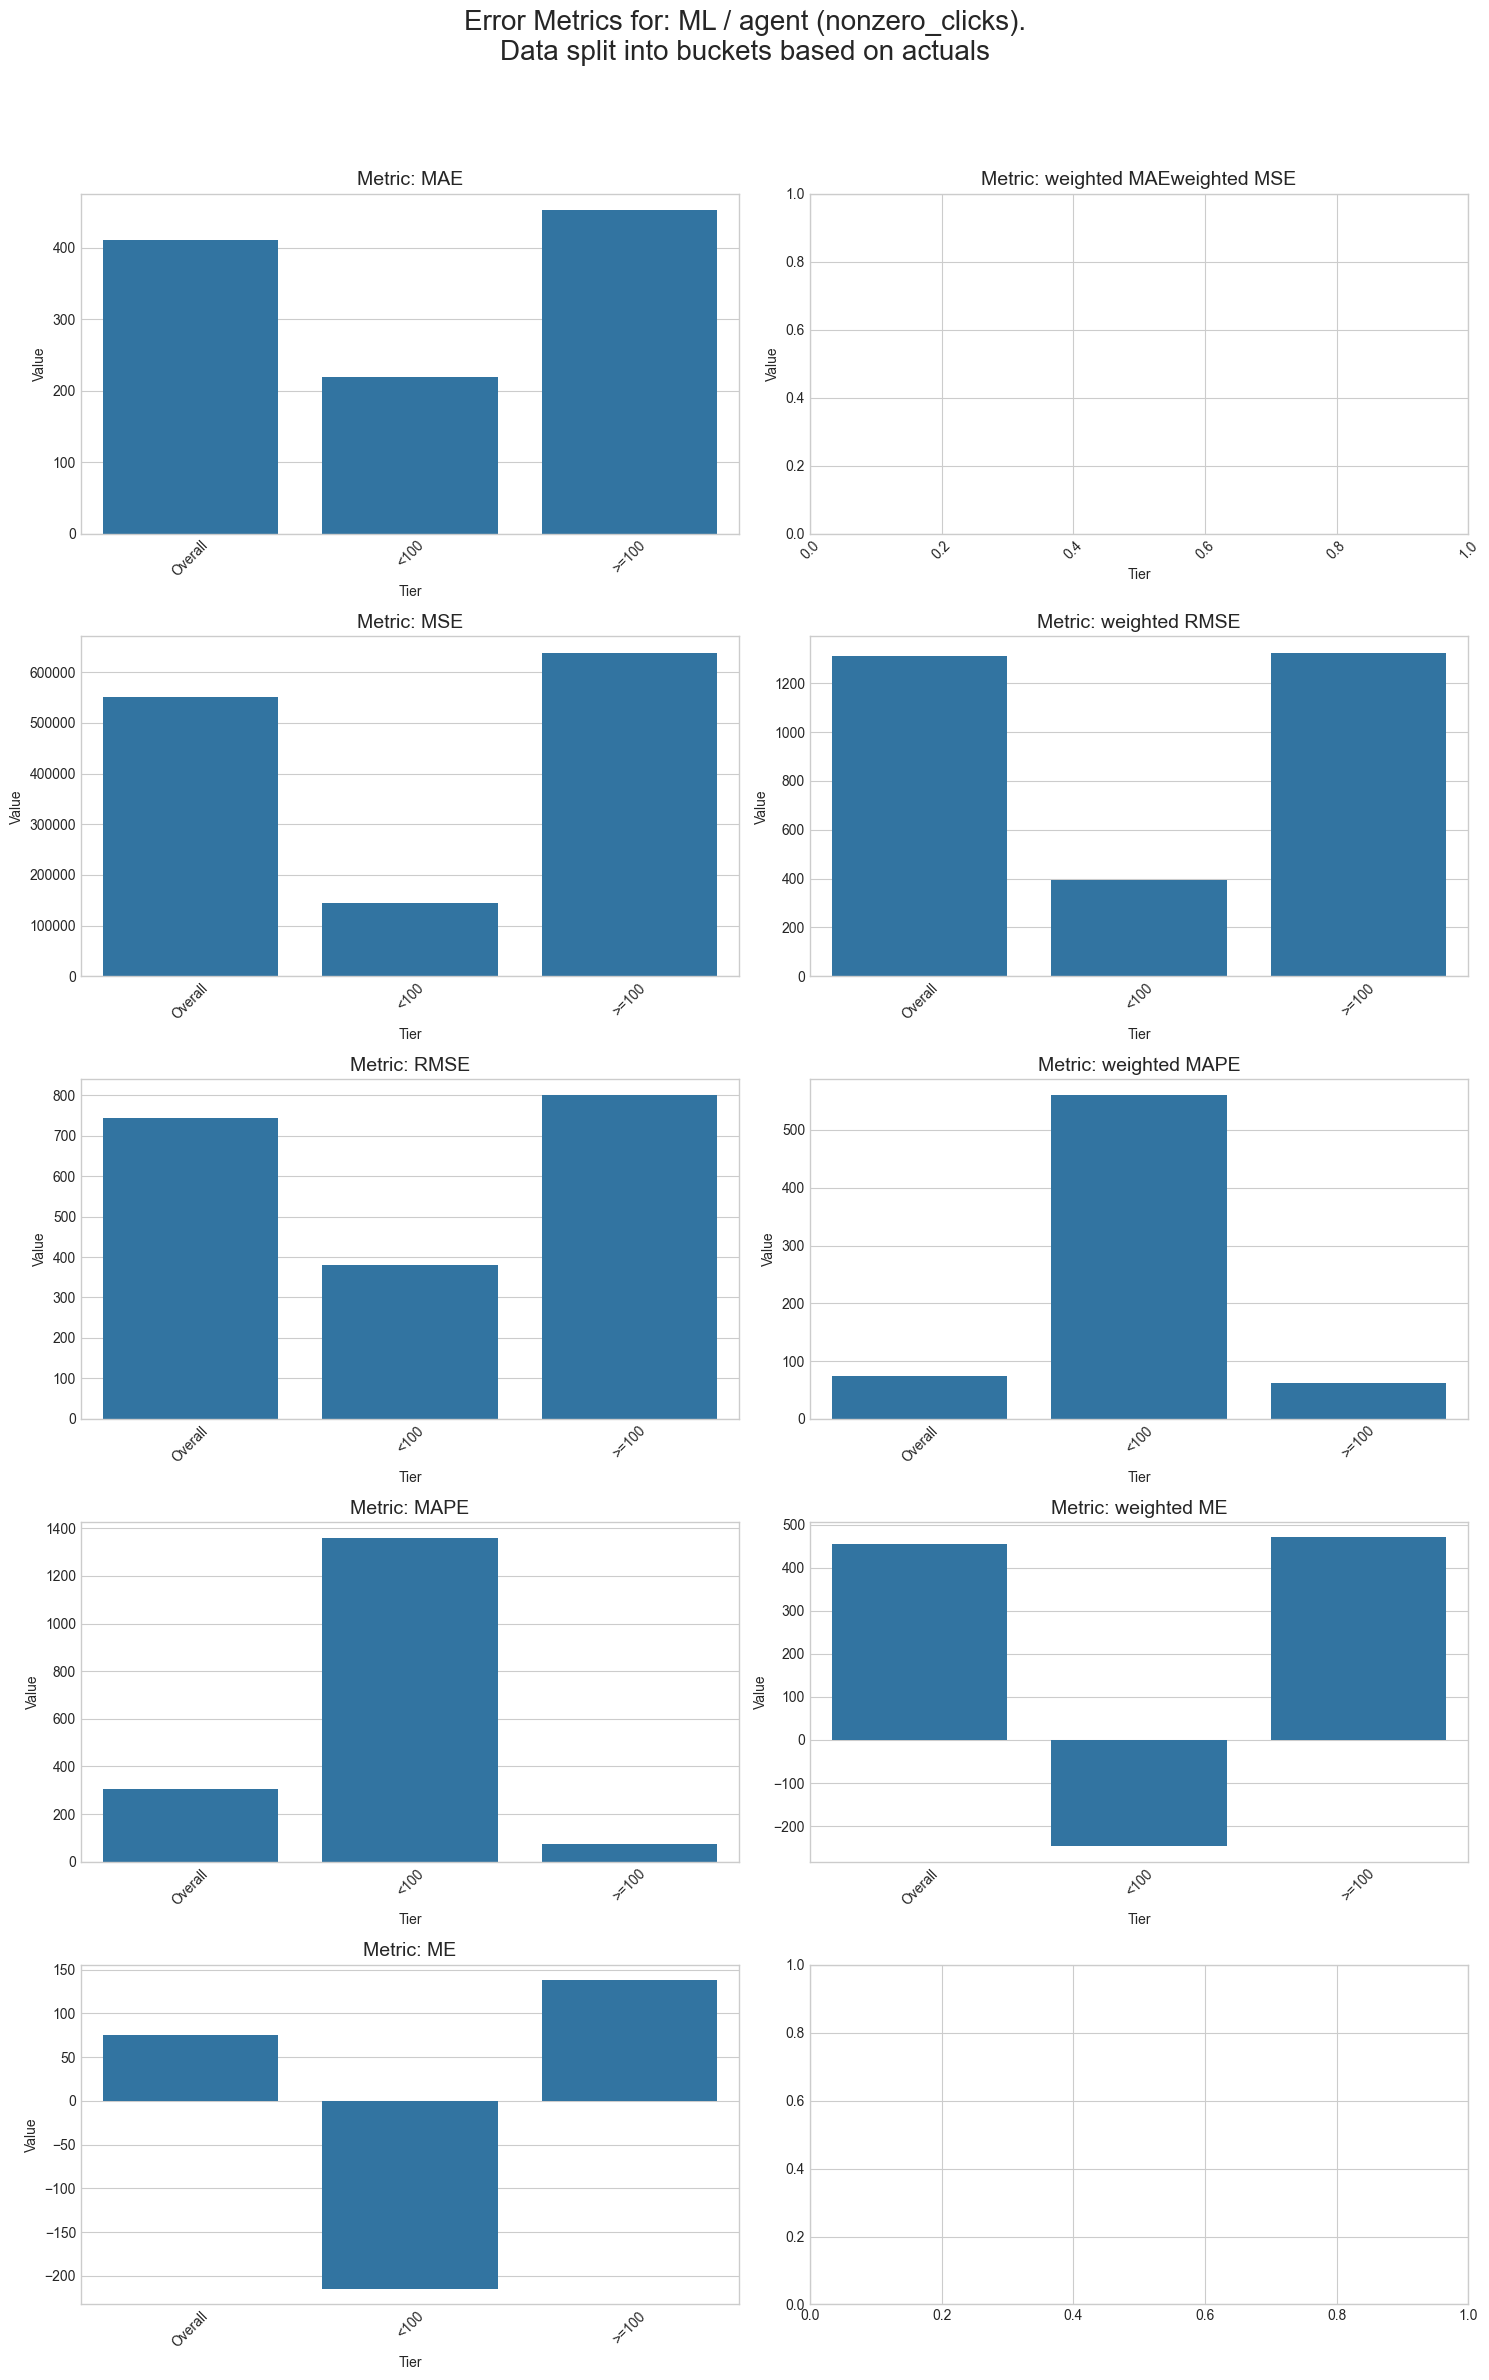

In [244]:
plot_metrics_subplots(adj_metrics_df,
                      reco_source='ML',
                      booking_source='agent',
                      data_subset='nonzero_clicks',
                      actual_cutting_column=True)

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_15079/3741136994.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Reco Source')


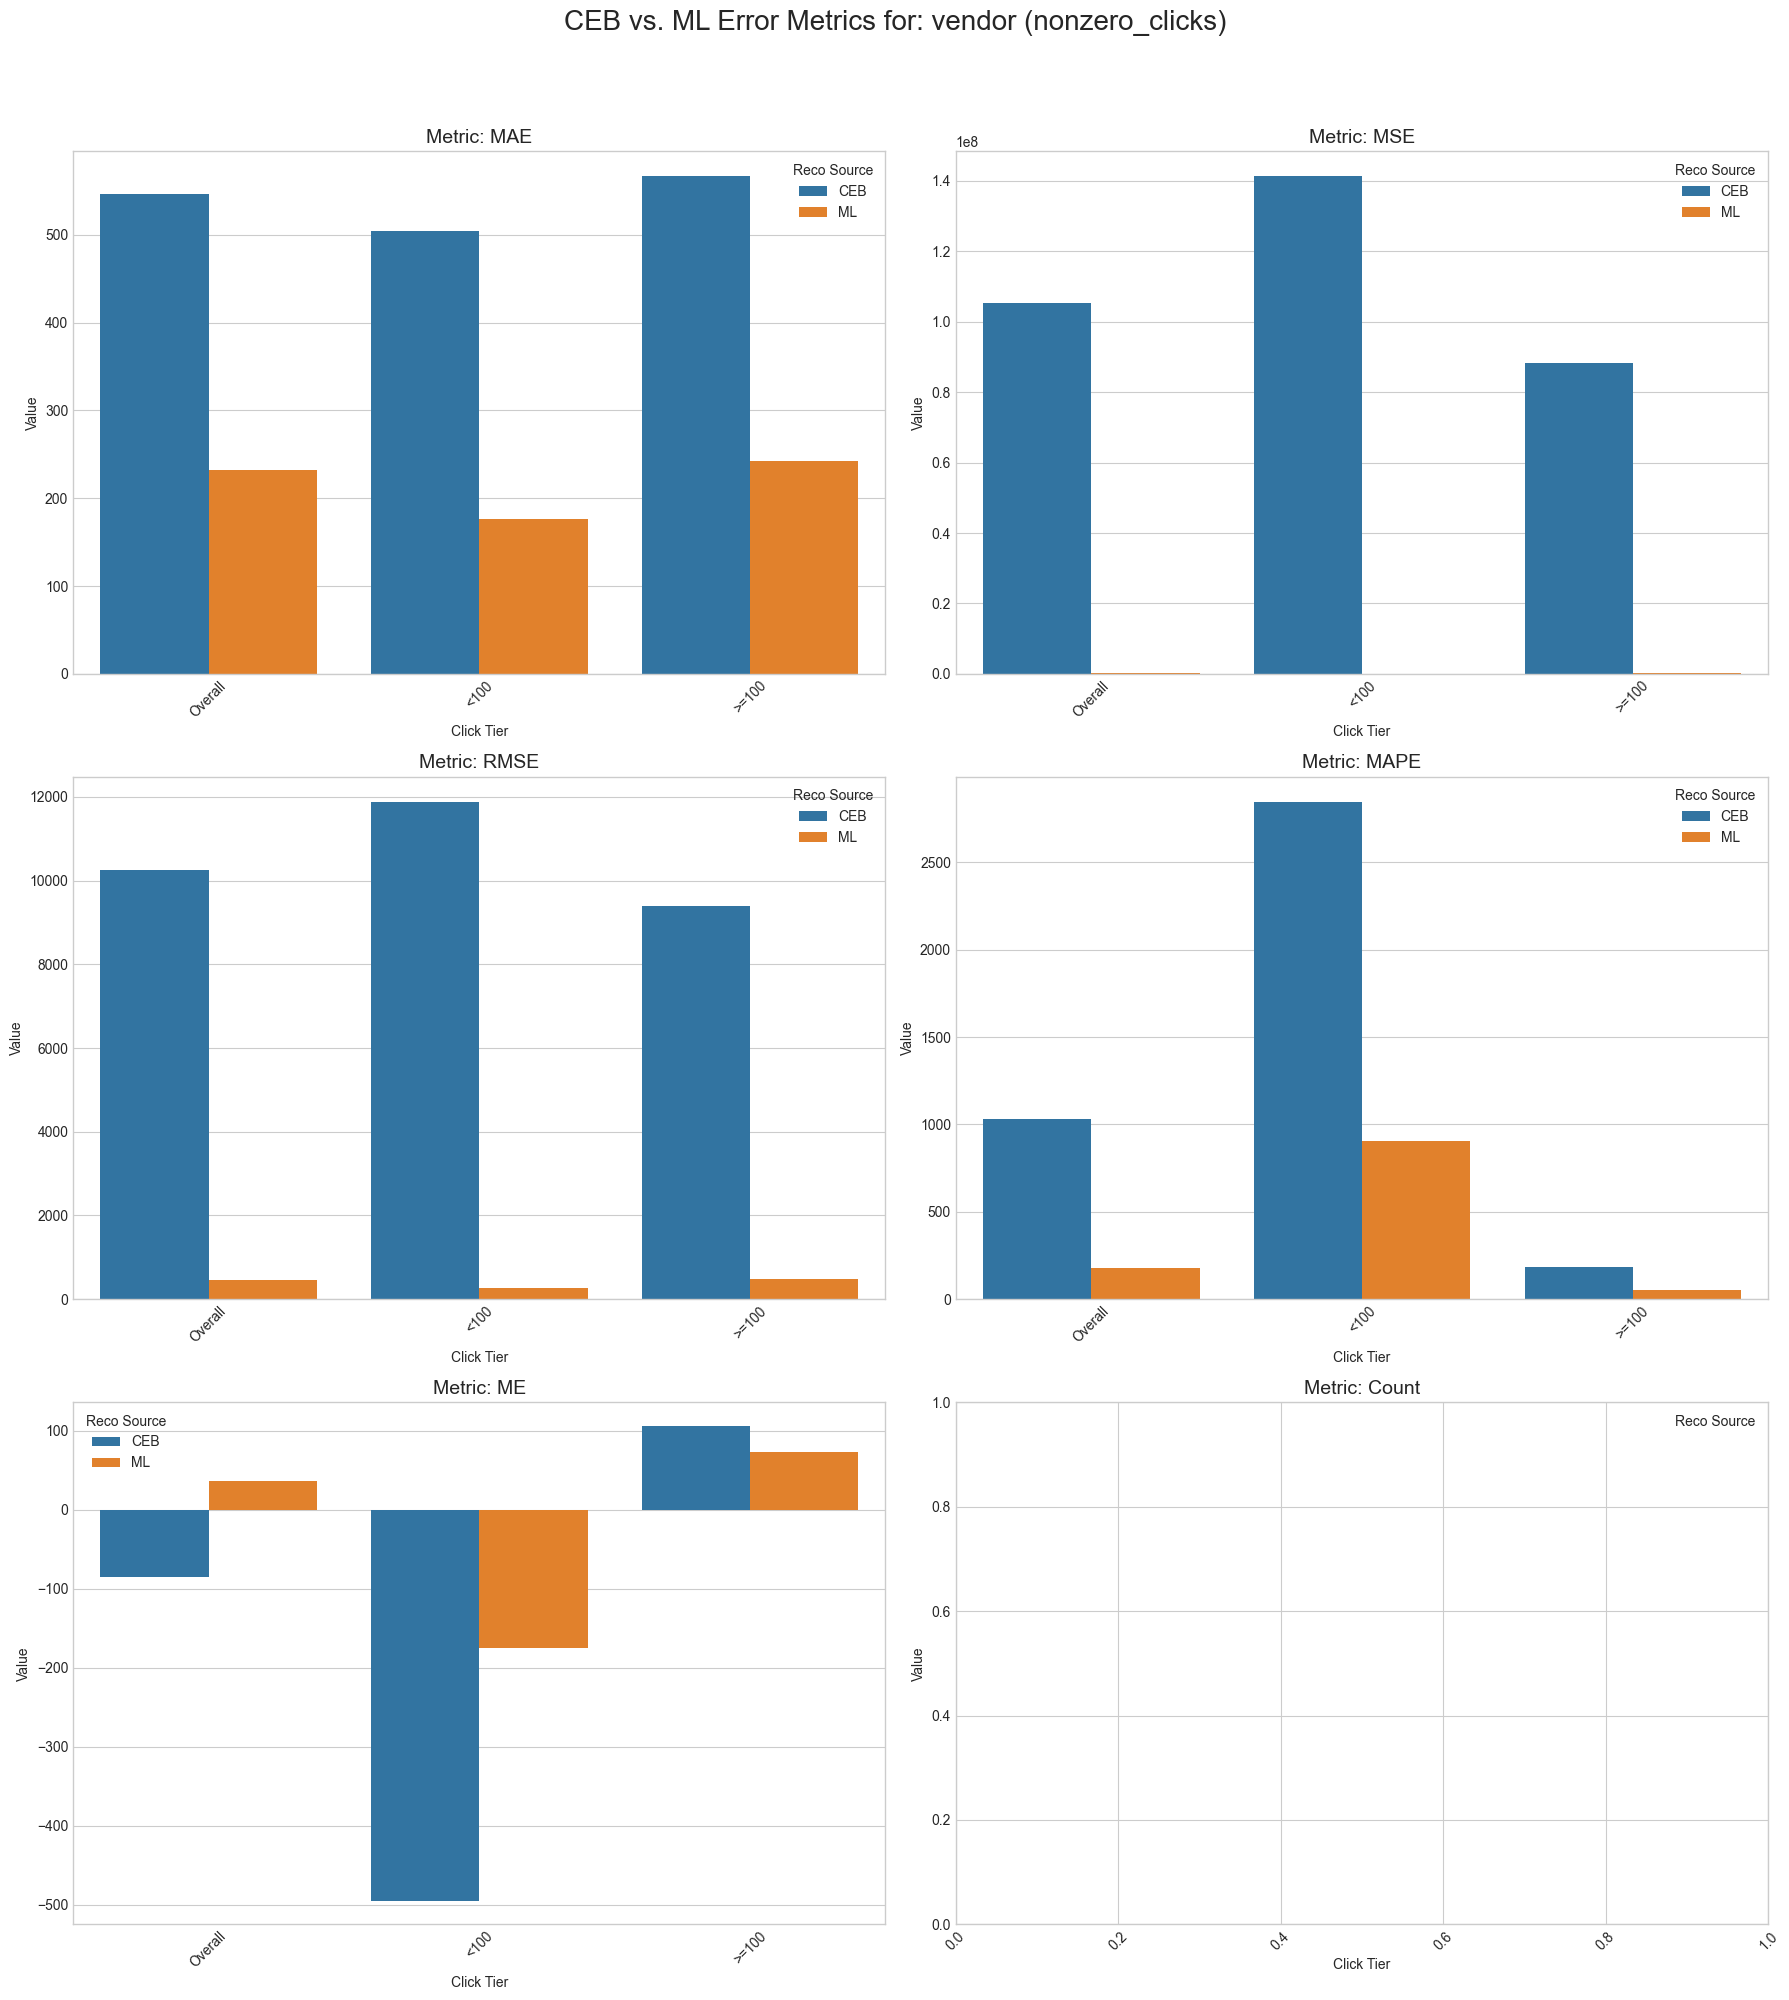

In [235]:
def plot_comparison_subplots(df, booking_source, data_subset):
    """
    Filters data for a booking_source and creates a 2x2 grid of grouped bar plots
    to compare CEB and ML reco_sources.
    """
    # Filter for the specific booking_source and data_subset, keeping both reco_sources
    plot_data = df.query(
        f"booking_source == '{booking_source}' and "
        f"data_subset == '{data_subset}'"
    )

    if plot_data.empty:
        print(f"No data found for the combination: {booking_source}, {data_subset}")
        return

    metrics_to_plot = ['MAE', 'MSE', 'RMSE', 'MAPE', 'ME', 'Count']
    fig, axes = plt.subplots(3, 2, figsize=(18, 21))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        # Use hue='reco_source' to create grouped bars
        sns.barplot(data=metric_data, x='tier', y='value', hue='reco_source', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=14)
        ax.set_xlabel('Click Tier')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Reco Source')

    fig.suptitle(f'CEB vs. ML Error Metrics for: {booking_source} ({data_subset})', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 3. Example Usage ---
plot_comparison_subplots(adj_metrics_df,
                         booking_source='vendor',
                         data_subset='nonzero_clicks')

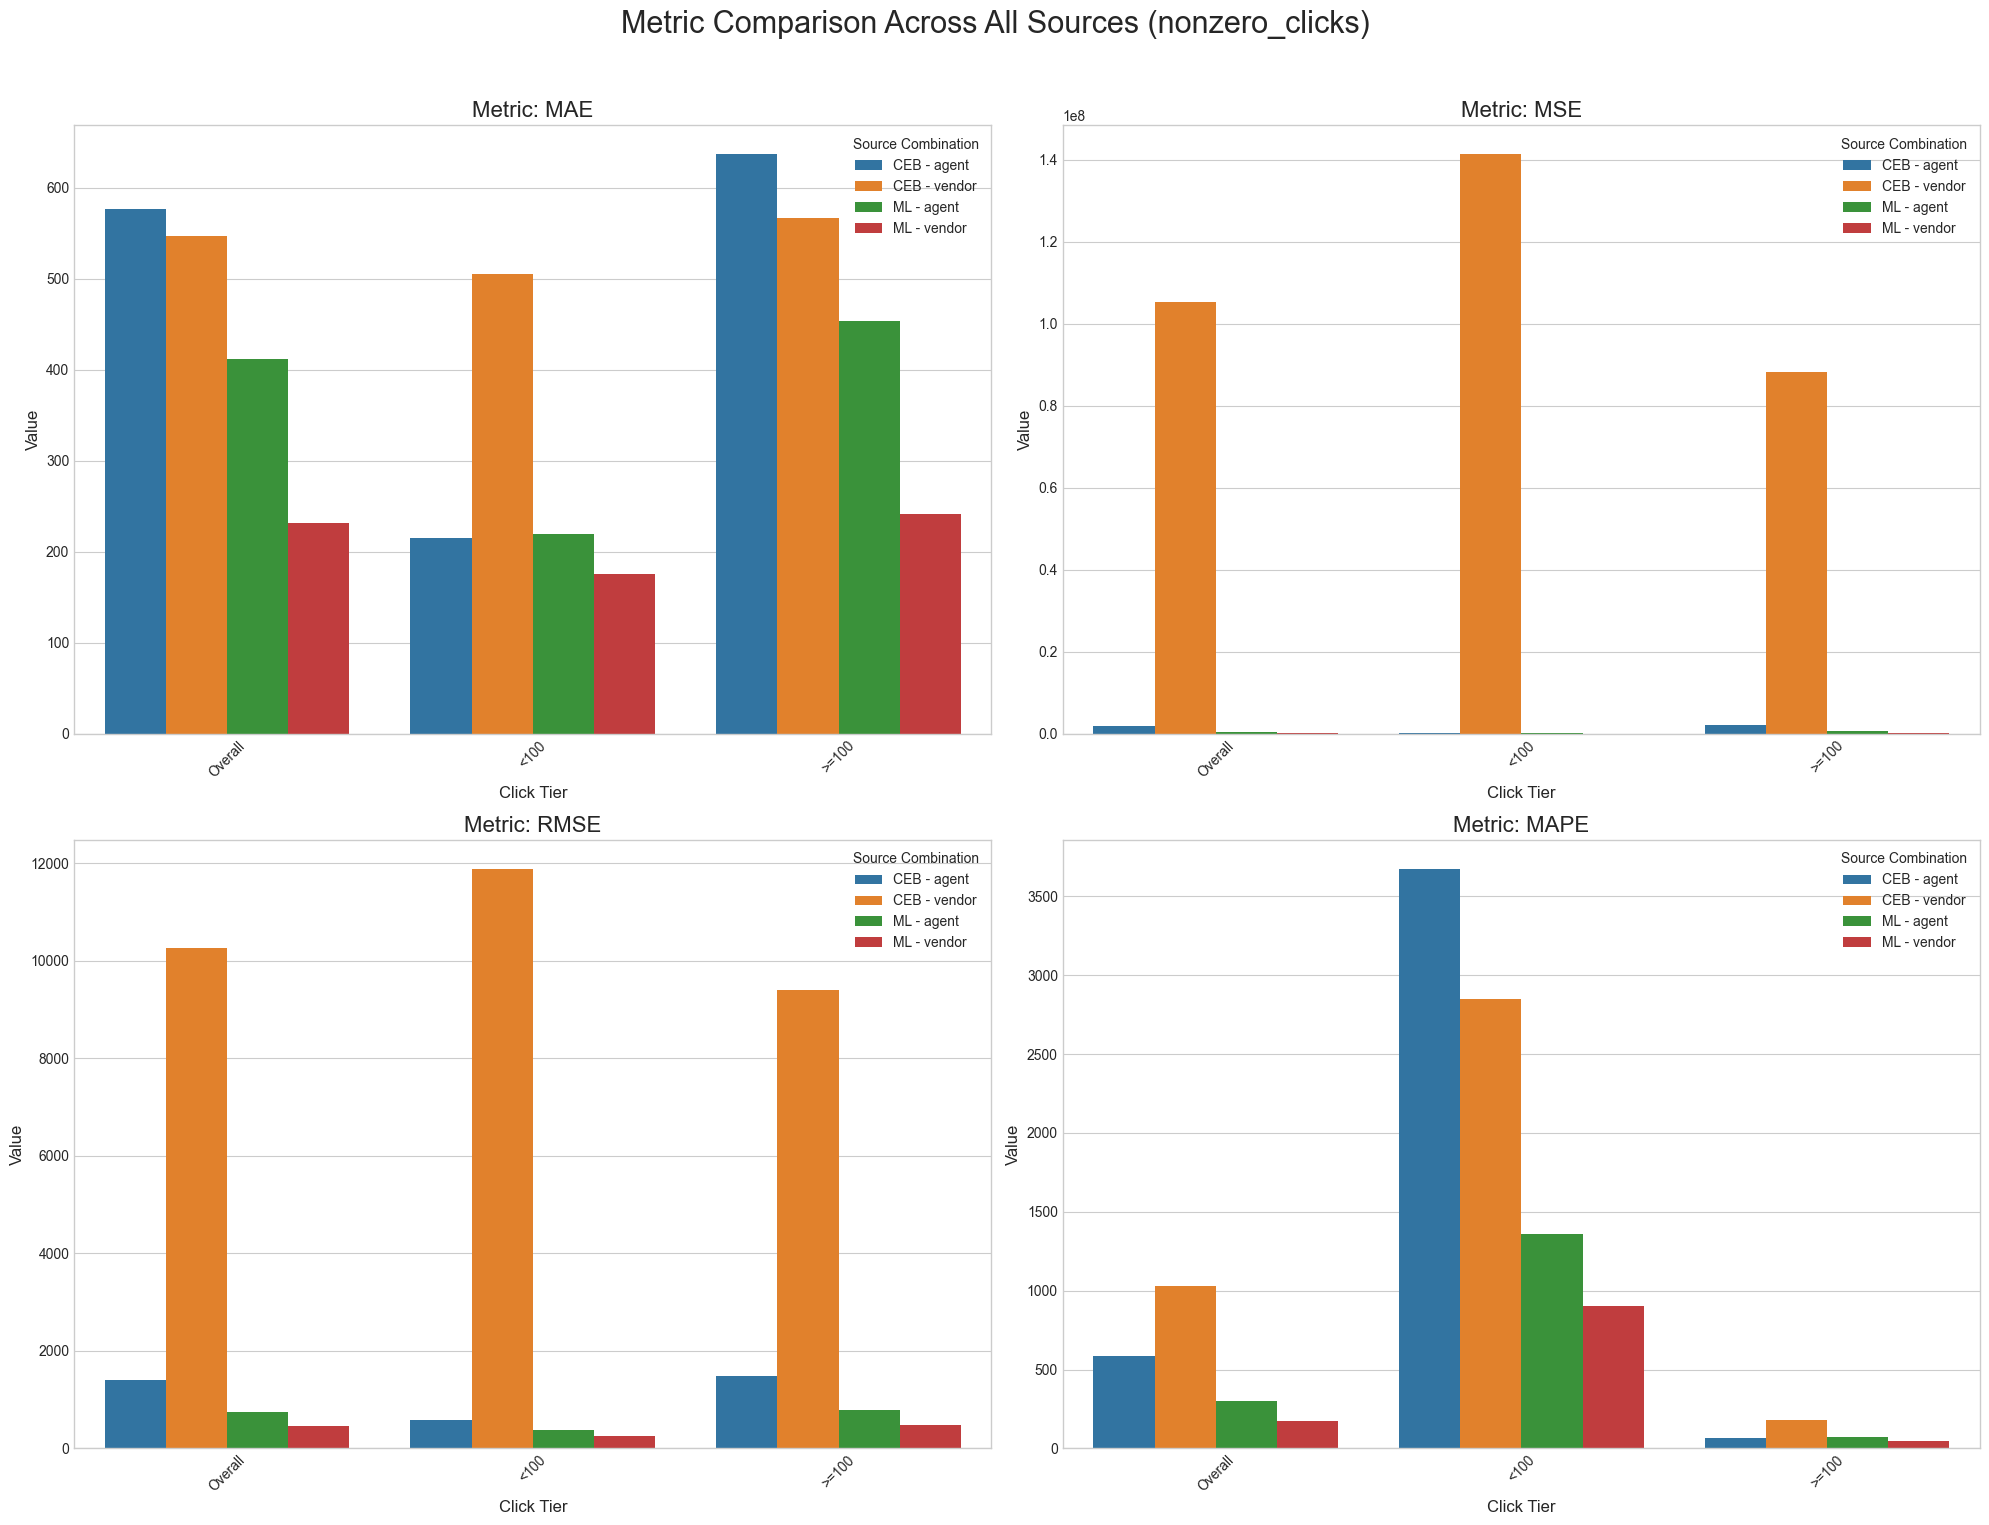

In [236]:
def plot_all_combinations_subplots(df, data_subset):
    """
    Creates a 2x2 grid of grouped bar plots to compare all combinations
    of reco_source and booking_source.
    """
    # Filter for the specific data_subset
    plot_data = df.query(f"data_subset == '{data_subset}'").copy()

    if plot_data.empty:
        print(f"No data found for data_subset: {data_subset}")
        return

    # Create a new column for the hue by combining the two source columns
    plot_data['combination'] = plot_data['reco_source'] + ' - ' + plot_data['booking_source']

    metrics_to_plot = ['MAE', 'MSE', 'RMSE', 'MAPE']
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        metric_data = plot_data[plot_data['metric'] == metric]
        
        # Use the new 'combination' column for the hue
        sns.barplot(data=metric_data, x='tier', y='value', hue='combination', ax=ax)
        
        ax.set_title(f'Metric: {metric}', fontsize=16)
        ax.set_xlabel('Click Tier', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.legend(title='Source Combination')

    fig.suptitle(f'Metric Comparison Across All Sources ({data_subset})', fontsize=22)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- 3. Example Usage ---
plot_all_combinations_subplots(adj_metrics_df,
                               data_subset='nonzero_clicks')

CEB is really bad

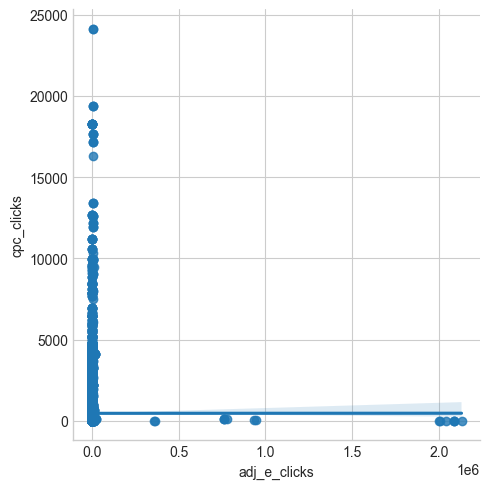

In [188]:
tmp = df.loc[(df.booking_source == 'vendor') & (df.reco_source == 'CEB')]
sns.lmplot(data=tmp, x='adj_e_clicks', y='cpc_clicks')


In [189]:
tmp.sort_values(by='adj_e_clicks', ascending=False).head(10)

,reco_source,booking_source,global_entity_id,vendor_id,date_month,management_entity,campaign_id,booked_budget,cpc_clicks,cpc_orders,...,k_c,b_c,k_o,b_o,k_r,b_r,adj_e_clicks,adj_e_orders,adj_e_roas,poisson_clicks
8853,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.804348,-2.173913,0.456522,-1.260870,0.0,3.0,2.128527e+06,255422.195652,3.0,0
10882,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-2.659574,0.446809,-1.319149,0.0,3.0,2.083238e+06,249987.595745,3.0,0
9037,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-2.659574,0.170213,0.021277,0.0,3.0,2.083238e+06,95233.893617,3.0,0
10296,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.723404,-6.382979,0.446809,-1.765957,0.0,3.0,2.083235e+06,249987.148936,3.0,0
7501,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.645833,0.520833,0.437500,-0.937500,0.0,3.0,2.039841e+06,244779.875000,3.0,0
10138,CEB,vendor,FP_TW,p7lo,2025-06-01,Foodpanda APAC,683bf90c31de582dd6aa4e40,442277.000000000,0,0,...,4.528986,-48.188406,0.753623,-7.898551,0.0,3.0,2.003018e+06,333302.304348,3.0,0
9586,CEB,vendor,FP_TW,samu,2025-06-01,Foodpanda APAC,683eb3b5c0a27cec0f9acbaa,559499.000000000,0,0,...,3.571429,0.000000,0.428571,-1.000000,0.0,3.0,1.998211e+06,239784.285714,3.0,0
13657,CEB,vendor,HS_SA,130003,2025-06-01,HungerStation,6845afb9633cc7bebffb40eb,468021.000000000,64,4,...,2.016129,-27.419355,0.100806,-2.370968,0.0,3.0,9.435633e+05,47177.165323,3.0,60
13517,CEB,vendor,HS_SA,130003,2025-06-01,HungerStation,6845afb9633cc7bebffb40eb,468021.000000000,64,4,...,1.992032,-28.286853,0.099602,-2.414343,0.0,3.0,9.322845e+05,46613.223108,3.0,61
3963,CEB,vendor,FP_MY,vj0e,2025-06-01,Foodpanda APAC,683f9cef0329005845388a51,87629.000000000,114,7,...,8.870968,-25.000000,0.387097,-1.000000,0.0,3.0,7.773290e+05,33919.903226,3.0,110


In [190]:
max_clicks = tmp.cpc_clicks.max()
# how many rows are greater than five times this?
outliers = tmp.adj_e_clicks >= max_clicks * 5
tmp.loc[outliers].shape[0]


15

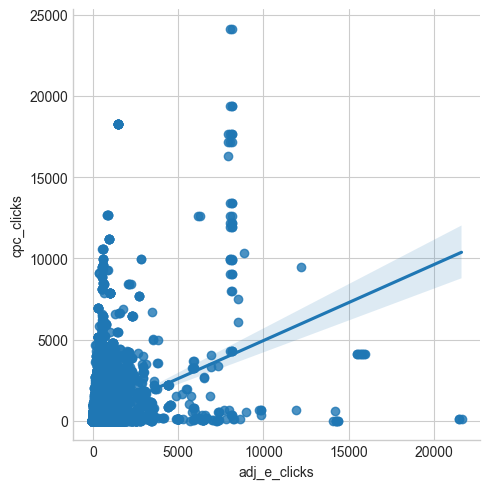

In [191]:
sns.lmplot(data=tmp.loc[tmp.adj_e_clicks <= max_clicks * 5], x='adj_e_clicks', y='cpc_clicks')